In [1]:
3+6

9

# Master File

# Tools & Libraries

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [3]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import (boxplot_histogram)

from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx,
    store_bin
    )


In [4]:
from pa_lib.data import desc_col

In [5]:
from IPython.display import display
pd.options.display.max_columns = None


In [9]:
# Lazy Recursive Job Dependency Request:
from pa_lib.job import request_job

################################################################################
## Recursive Dependency Check:
request_job(
    job_name= "ek_info_prepare.py",
    #current = "This Week",
    current = "Today"
    ) 
# output: ek_info.feather

10:06:03 [INFO] [ipykernel_launcher.py] requests 'ek_info_prepare.py'
10:06:03 [INFO] [ipykernel_launcher.py]: Not running job 'ek_info_prepare.py': result is current ('Today') from 2019-11-15 10:04:03.589374.


# Load Dataset (Data Preparation)

In [10]:
from vkprog_data_prep import bd_train_scoring


10:06:10 [INFO] [ipykernel_launcher.py] requests 'bd_prepare.py'
10:06:10 [INFO] [ipykernel_launcher.py]: Not running job 'bd_prepare.py': result is current ('Today') from 2019-11-15 09:59:40.367433.


http://www.whatweekisit.org/

In [11]:
%%time
# Wall time: 38.5 s

# 2019-10-21 => Calendar week 43
(training_all,
 scoring_all,
 feature_colnames_bd,
 feature_colnames_dates,
 feature_colnames_branchen
    ) = bd_train_scoring(
            day            = 18, # a Monday
            month          = 11,
            year_score     = 2019,
            year_train     = 2018,
            year_span      = 4,
            scale_features = True,
            sales_filter   = True
            #Sales Filter: Keine Langzeitverträge, Eigenwerbung, 
            #              Logistik für Dritte, politisch... etc.
            )

10:10:03 [INFO] Started loading binary file
10:10:03 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
10:10:03 [INFO] Finished loading binary file in 0.19s (0.86s CPU)
10:10:05 [INFO] True: Filters applied, defined by Sales
10:10:05 [INFO] Period: KW_2
10:10:05 [INFO] Calculate Reservation...
10:10:05 [INFO] Calculate Aushang...
10:10:06 [INFO] Merge Results...
10:10:06 [INFO] aggregate_bookings: Done.
10:10:06 [INFO] current_yyyykw: 201947
10:10:06 [INFO] training_yyyykw:201847
10:10:06 [INFO] Computing: Pivot Table
10:10:06 [INFO] Running: booking_yearly_totals(YYYYKW, year_span) 
10:10:06 [INFO] Final merge
10:10:06 [INFO] Computing: Pivot Table
10:10:07 [INFO] Running: booking_yearly_totals(YYYYKW, year_span) 
10:10:07 [INFO] Final merge
10:10:11 [INFO] Scaling features
10:10:13 [INFO] Finished.
Wall time: 10.4 s


In [14]:
print(f"training_all.shape: {training_all.shape}")
print(f"scoring_all.shape: {scoring_all.shape}")
print("\ntraining_all\n")
display(training_all.describe())
print("\nscoring_all\n")
display(scoring_all.describe())

training_all.shape: (12620, 309)
scoring_all.shape: (12763, 309)

training_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_43,Netto_Sum_Aus_RY_0_KW_45,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_43,Netto_Sum_Res_RY_0_KW_45,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,


scoring_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_43,Netto_Sum_Aus_RY_0_KW_45,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_43,Netto_Sum_Res_RY_0_KW_45,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,

In [15]:
set(training_all.columns == scoring_all.columns)

{True}

In [17]:
# Search for NULLS
display(desc_col(training_all)
        .sort_values("NULLS", ascending=False)
        .head(2)
        )

display(desc_col(scoring_all)
        .sort_values("NULLS", ascending=False)
        .head(2)
       )

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12620,12620
Netto_Sum_Res_RY_3_KW_45,float64,0/12620,331


,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12763,12763
Netto_Sum_Res_RY_3_KW_45,float64,0/12763,387


In [18]:
#desc_col(training_all.loc[:,feature_colnames_branchen])
#desc_col(scoring_all.loc[:,feature_colnames_branchen])

predictor: Erste_Buchung_Delta
Target_Res_flg: True


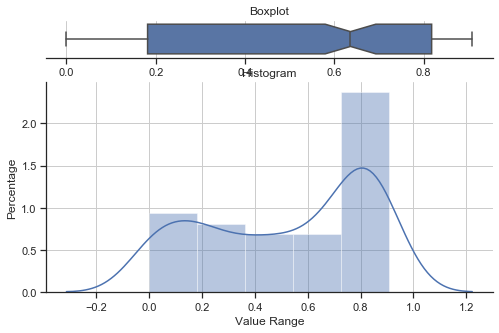

Target_Res_flg: False


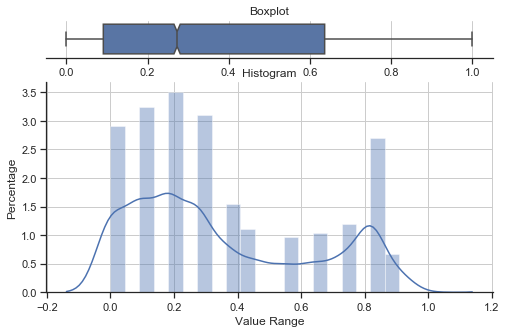


###########################################################

predictor: Letzte_Buchung_Delta
Target_Res_flg: True


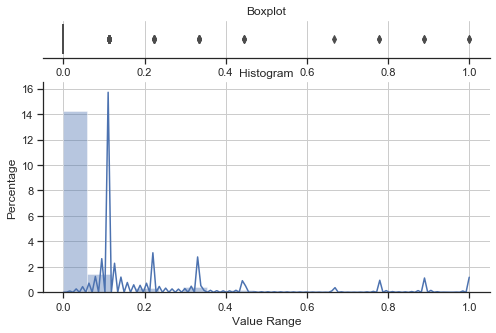

Target_Res_flg: False


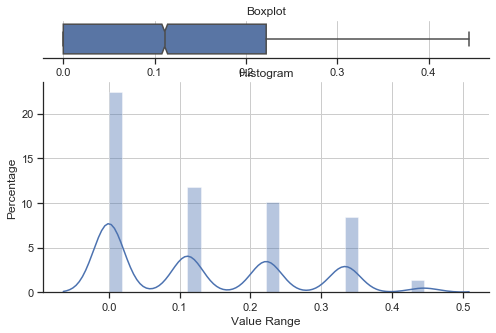


###########################################################

predictor: Erste_Letzte_Buchung_Delta
Target_Res_flg: True


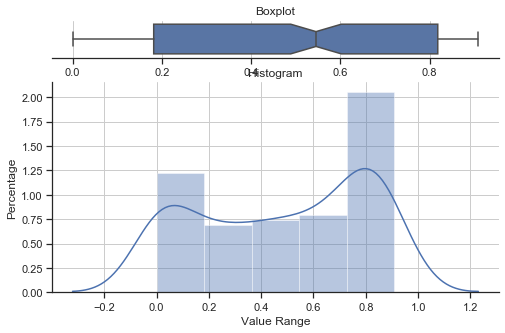

Target_Res_flg: False


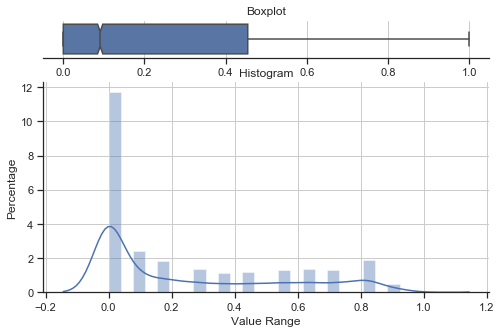


###########################################################



In [26]:
temp_df = training_all
for predictor in feature_colnames_dates:
    print(f"predictor: {predictor}")
    
    for boolean in [True, False]:
        print(f"Target_Res_flg: {boolean}")
        
        boxplot_histogram(
            temp_df.loc[temp_df.Target_Res_flg == boolean , # row filter
                        predictor ],           # column
            figsize=(8,5)
            )
    print("\n###########################################################\n")

del temp_df

## CRM Data

In [27]:
from vkprog_crm_prep  import crm_train_scoring

11:10:47 [INFO] [ipykernel_launcher.py] requests 'crm_prepare.py'
11:10:47 [INFO] [ipykernel_launcher.py]: Not running job 'crm_prepare.py': result is current ('Today') from 2019-11-15 09:36:36.314548.


In [28]:
(crm_train_df,
 crm_score_df,
 feature_colnames_crm
) = crm_train_scoring(
    day        = 18,
    month      = 11,
    year_score = 2019,
    year_train = 2018,
    year_span  = 4
    )

11:10:51 [INFO] Start.
11:10:51 [INFO] Started loading binary file
11:10:51 [INFO] Reading from file C:\Users\stc\data\vkprog\crm_data_vkprog.feather
11:10:51 [INFO] Finished loading binary file in 0.22s (0.22s CPU)
11:11:03 [INFO] Finished.


In [29]:
from pa_lib.data import desc_col

In [31]:
def scaling_crm_add2master(master_df,crm_df,feature_colnames_crm):
    
    container_df = pd.merge(master_df, crm_df,how="left", on="Endkunde_NR")

    for col_name in list(
        np.compress(
            ['RY'== x[0:2] for x in feature_colnames_crm],
            feature_colnames_crm
            )
        ):
        
        container_df.loc[:,col_name] = container_df.loc[:,col_name].fillna(0)
        
        max_ = np.nanmax(
            container_df.loc[:,col_name]
            )
        
        min_ = np.nanmin(
            container_df.loc[:,col_name]
            )
        
        if min_ == max_:
            container_df.loc[:,col_name] = 0
        
        else:
            container_df.loc[:,col_name] = (
                (container_df.loc[:,col_name] - min_) / (max_ - min_)
                )

    for col_name in list(
        np.compress(
            ['Letzter'== x[0:7] for x in feature_colnames_crm],
            feature_colnames_crm
            )
        ):
        
        max_ = np.nanmax(container_df.loc[:,col_name]) 
        # -> those who have never been contacted
        #    will be put together with the max-ones.
        
        container_df.loc[:,col_name] = (
            container_df.loc[:,col_name]
                        .fillna(max_)
            ) # No more NaNs!
        
        min_ = np.nanmin(container_df.loc[:,col_name])
        
        if max_ == min_:
            container_df.loc[:,col_name] = 1
            
        else:
            container_df.loc[:,col_name] = container_df.loc[:,col_name]/max_
            # scaling, doesn't need 0
    
    return container_df

In [32]:
training_all = scaling_crm_add2master(
    master_df            = training_all,
    crm_df               = crm_train_df,
    feature_colnames_crm = feature_colnames_crm
    )

In [33]:
scoring_all  = scaling_crm_add2master(
    master_df            = scoring_all,
    crm_df               = crm_score_df,
    feature_colnames_crm = feature_colnames_crm
    )

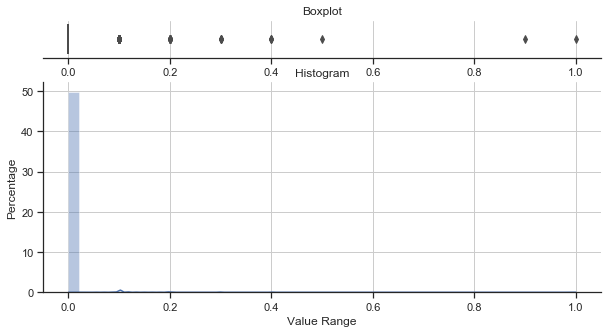

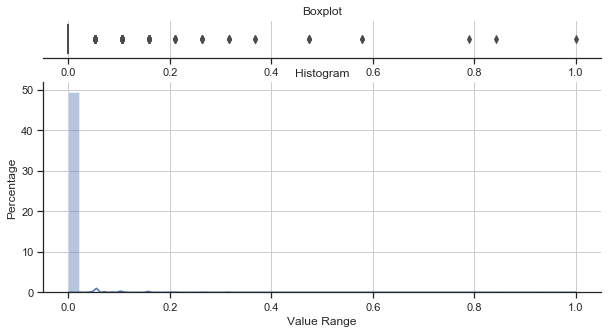

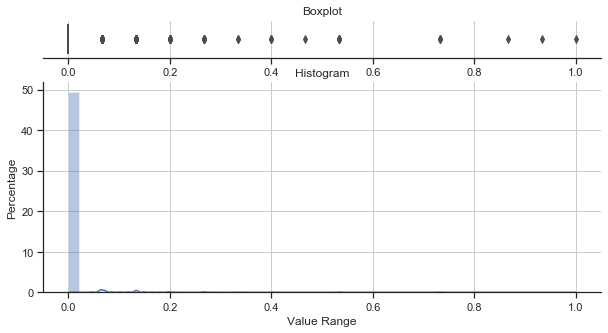

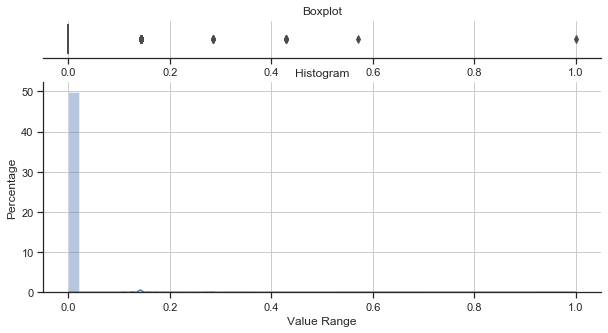

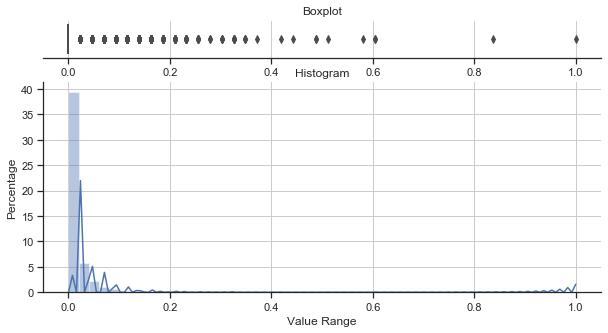

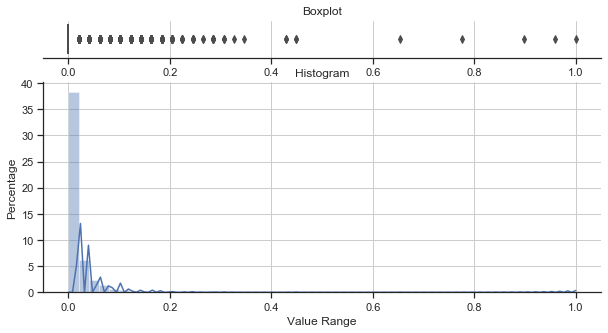

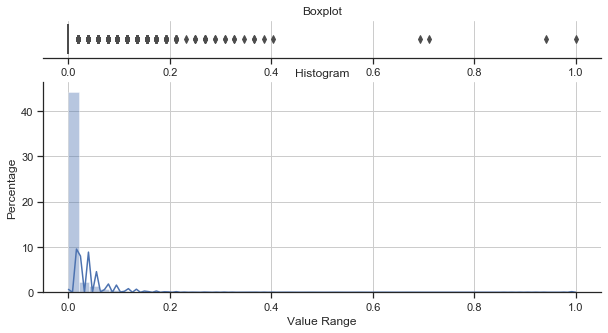

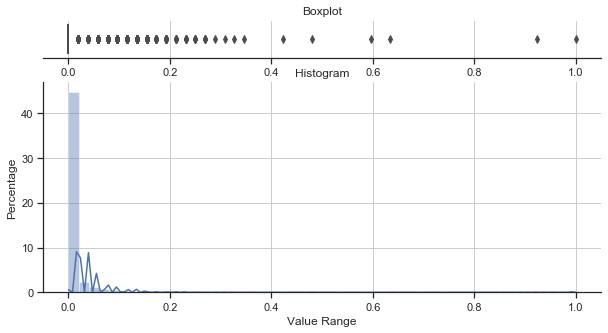

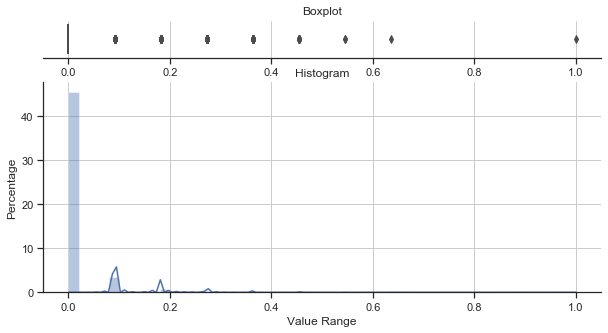

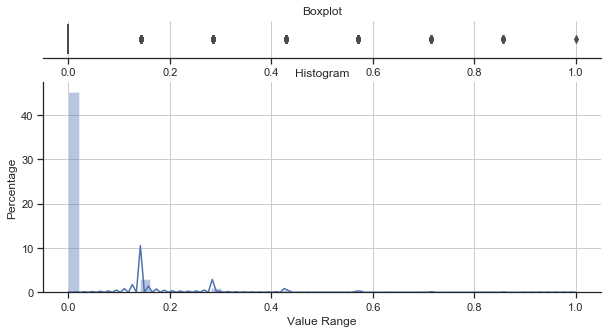

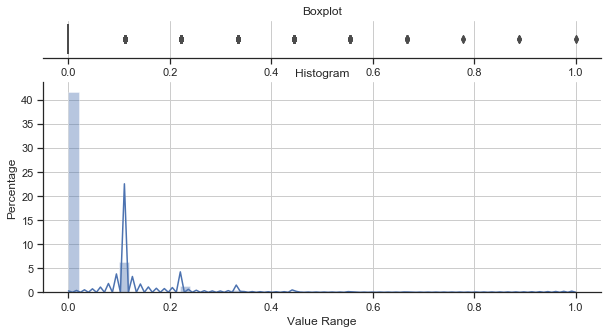

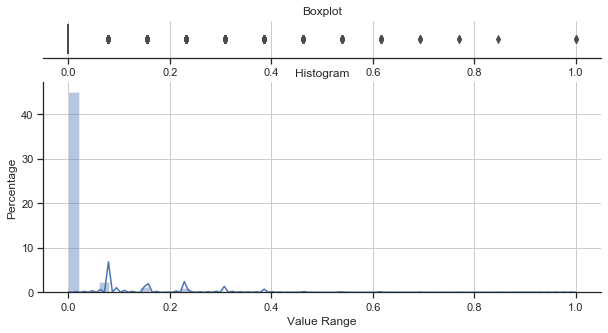

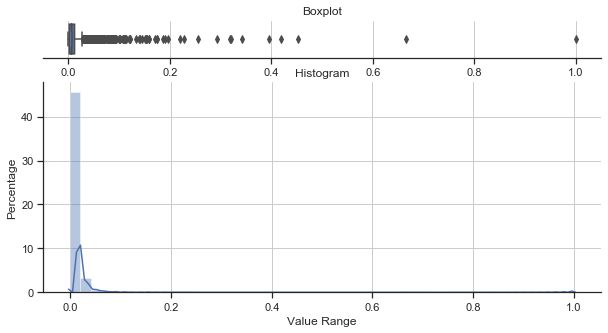

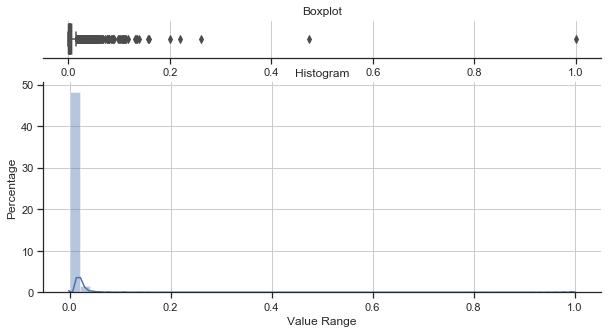

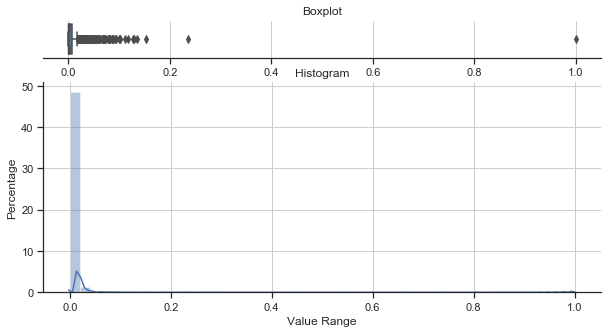

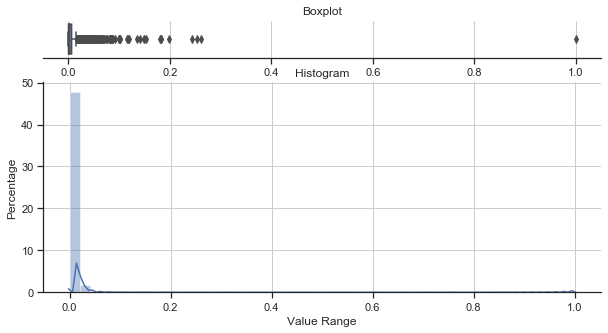

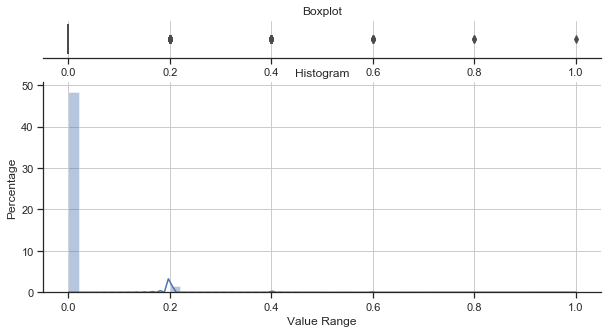

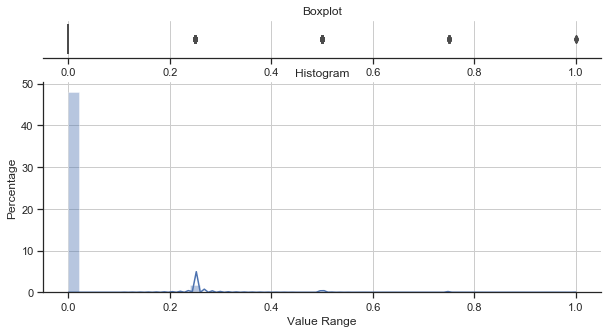

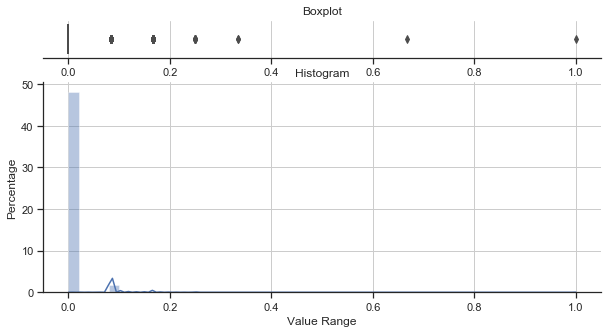

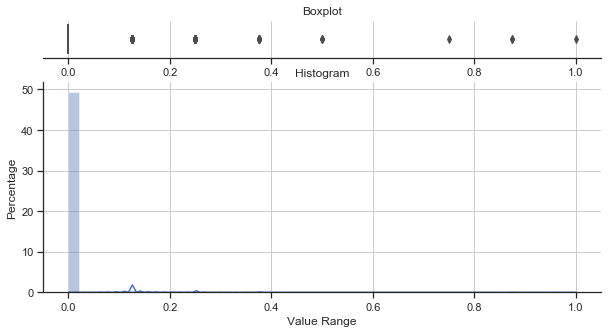

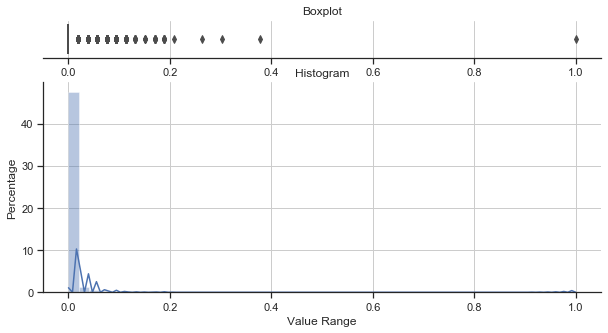

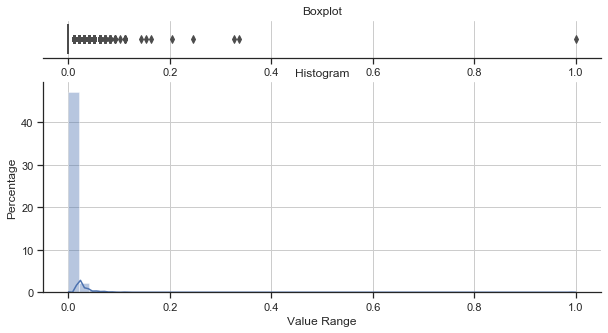

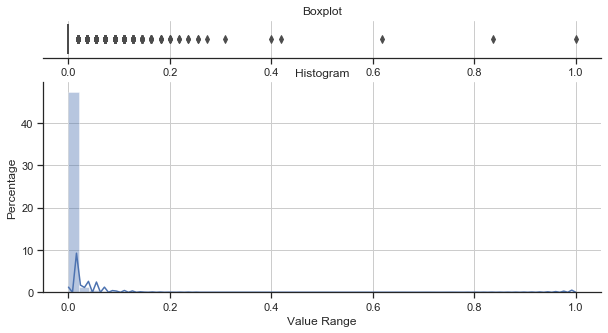

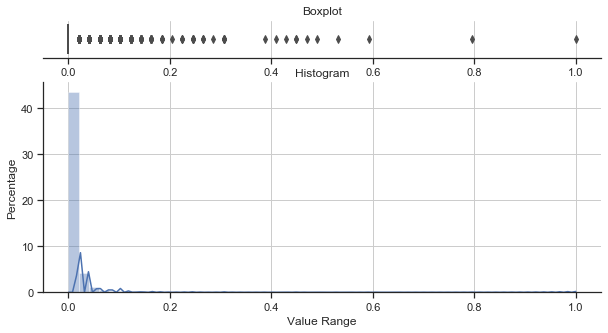

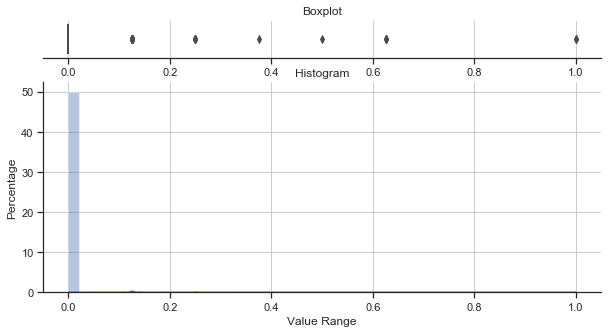

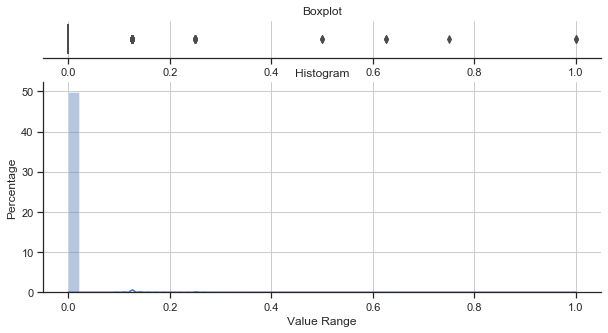

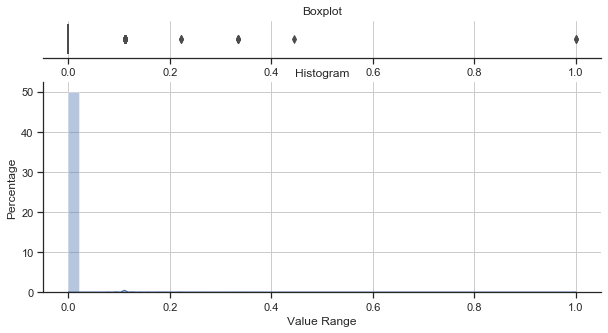

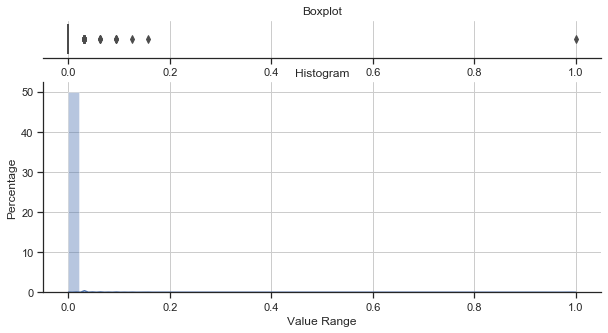

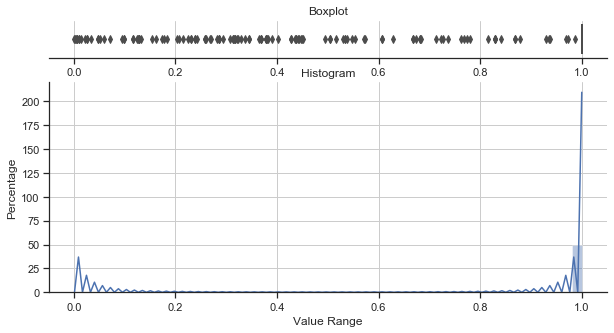

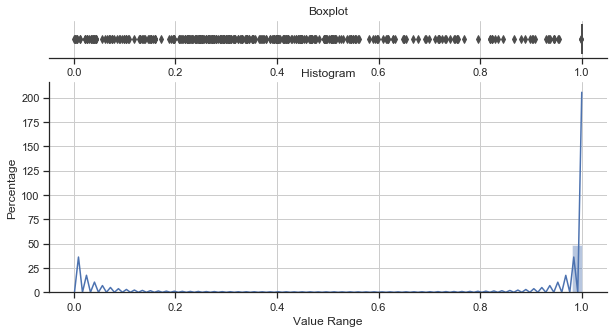

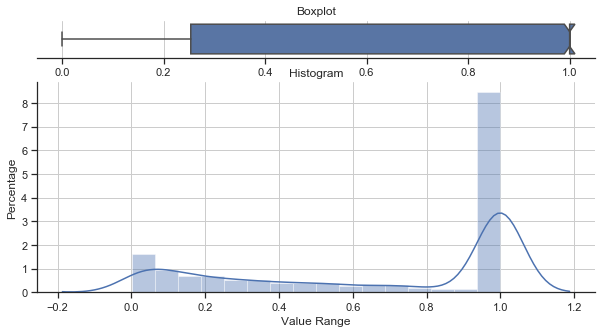

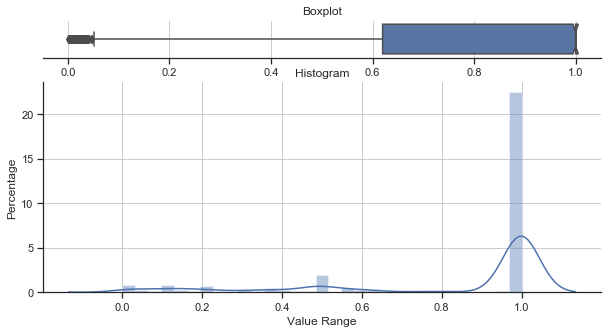

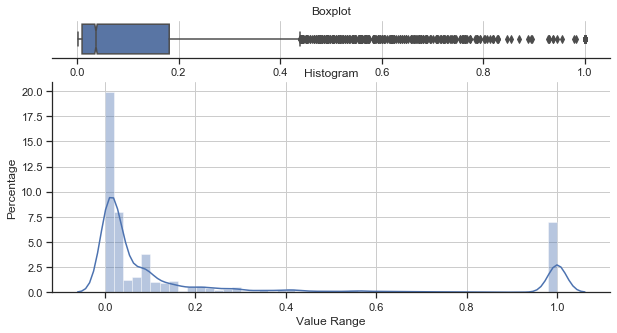

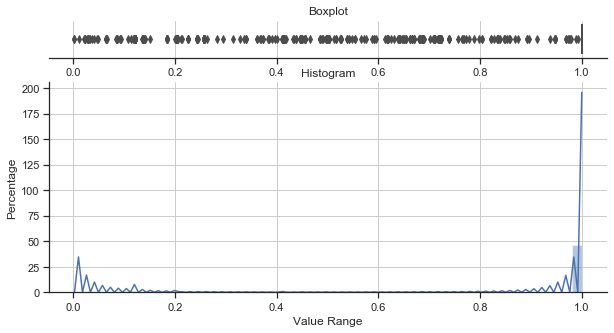

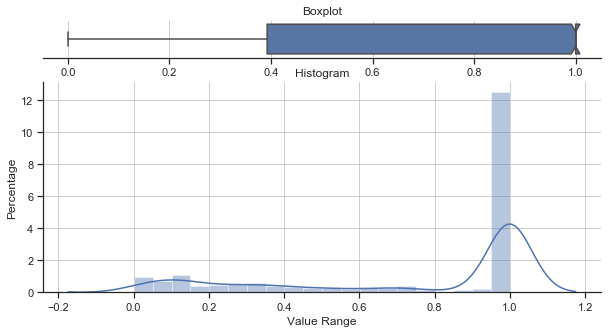

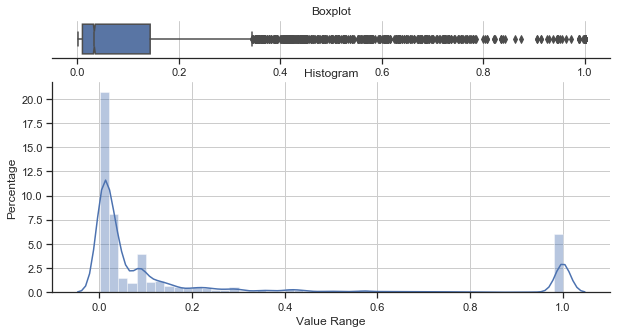

In [35]:
for x in feature_colnames_crm:
    boxplot_histogram(
        training_all.loc[:,x],
        figsize=(10,5)
        )

In [36]:
print(training_all.shape)
print(scoring_all.shape)

(12620, 345)
(12763, 345)


# Modeling

## Define Columns: Features versus Targets

In [37]:
from itertools import compress

features = (
    feature_colnames_bd         # Booking data
    + feature_colnames_dates    # Dates related to bookings
    + feature_colnames_branchen # Branches
    + feature_colnames_crm      # CRM (customer-vkber interactions)
    )


feature_columns_boolean = pd.Series(features).str.match('^Target')
feature_columns = pd.Series(features).loc[~feature_columns_boolean]

feature_columns_boolean = pd.Series(training_all.columns).str.match('^Target')
target_columns = pd.Series(training_all.columns).loc[feature_columns_boolean]

del feature_columns_boolean

In [38]:
print(f"Number of features:\n{len(feature_columns)}\n")
print(f"Target columns:\n{target_columns}")

Number of features:
338

Target columns:
214               Target_Aus_flg
215               Target_Res_flg
216    Target_Sum_Aus_RY_0_KW_47
217    Target_Sum_Res_RY_0_KW_47
dtype: object


## Split ``training_all`` into training-set (``X_train``,``y_train``) and test-set (``X_test``,``y_test``)

In [39]:
df_features = (
    training_all
    .loc[:,feature_columns]
    .to_numpy()
    )

df_target   = (
    training_all
    .loc[:, "Target_Res_flg"]
    .to_numpy()
    )

df_scoring_features = (
    scoring_all
    .loc[:,feature_columns]
    .to_numpy()
    )

In [40]:
print(f"df_features.shape: {df_features.shape}")
print(f"df_target.shape:   {df_target.shape}")

df_features.shape: (12620, 338)
df_target.shape:   (12620,)


In [41]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    df_features,
    df_target,
    train_size=0.75,
    random_state=42
    )

In [42]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape.:", X_test.shape)
print("y_test.shape:",  y_test.shape)
print("\ndf_scoring_features.shape:", df_scoring_features.shape)

X_train.shape: (9465, 338)
y_train.shape: (9465,)
X_test.shape.: (3155, 338)
y_test.shape: (3155,)

df_scoring_features.shape: (12763, 338)


In [68]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(list(stats.describe(y_test)))


y_train:
0
False    9219
True      246
Name: 0, dtype: int64
DescribeResult(nobs=9465, minmax=(False, True), mean=0.025990491283676705, variance=0.02531766051819691, skewness=5.95838013038995, kurtosis=33.50229377822577)

y_test:
0
False    3090
True       65
Name: 0, dtype: int64
[3155, (False, True), 0.020602218700475437, 0.020184164801670602, 6.749777562050998, 43.559497137167085]


## Balance Training Dataset

In [69]:
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(random_state=42)

(X_train_balanced, y_train_balanced) = sm.fit_resample(X_train, y_train)

In [70]:
print('y_train_balanced:')
print(pd.DataFrame(y_train_balanced).groupby(0)[0].count())
print(stats.describe(y_train_balanced))

y_train_balanced:
0
False    9219
True     9219
Name: 0, dtype: int64
DescribeResult(nobs=18438, minmax=(False, True), mean=0.5, variance=0.2500135596897543, skewness=0.0, kurtosis=-2.0)


## Feature selection: SelectkBest

``SelectPercentile`` removes all but a user-specified highest scoring percentage of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

In [71]:
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif,
    #SelectPercentile
    )

from itertools import compress

In [72]:
%%time
#Wall time: 54 s

select = SelectKBest(
    score_func = mutual_info_classif,
    k          = 150 # How many features? (currently 219 is max)
    )

select.fit(
    X_train_balanced,
    y_train_balanced
    )

mask = select.get_support() # boolean array.

Wall time: 37.4 s


In [73]:
print(f"X_train_balanced.shape: {X_train_balanced.shape}")
print(f"X_train_balanced[:,mask].shape: {X_train_balanced[:,mask].shape}")

X_train_balanced.shape: (18438, 338)
X_train_balanced[:,mask].shape: (18438, 150)


In [74]:
# Reassign variable names due to lazyness
feature_columns  = feature_columns.loc[mask]
X_train_balanced = X_train_balanced[:,mask]
X_train          = X_train[:,mask]
X_test           = X_test[:,mask]
X_scoring        = df_scoring_features[:,mask]

In [75]:
print("X_scoring.shape:",X_scoring.shape)

X_scoring.shape: (12763, 150)


## Model Training

### Logistic Regression (base model)

In [76]:
from sklearn.linear_model import LogisticRegression

In [78]:
%%time
# Wall time: 1min 13s
logreg_C1000 = LogisticRegression(
    n_jobs   = -1,
    solver   = "sag",
    max_iter = 100000,
    C        = 1000 #adjustable, bigger mean less restriction on coefficients
    ).fit(
        X_train_balanced,
        y_train_balanced
        ) # bigger C

print(f"Training set score: {logreg_C1000.score(X_train_balanced, y_train_balanced)}")
print(f"Test set score: {logreg_C1000.score(X_test, y_test)}")

Training set score: 0.8180930686625447
Test set score: 0.8047543581616482
Wall time: 49.5 s


In [79]:
%%time
# Wall time: 543 ms
logreg_C0001 = LogisticRegression(
    n_jobs=-1,
    solver="sag",
    max_iter=100000,
    C=0.001 #adjustable, bigger mean less restriction on coefficients
    ).fit(
        X_train_balanced,
        y_train_balanced
        ) # bigger C

print(f"Training set score: {logreg_C0001.score(X_train_balanced,y_train_balanced)}")
print(f"Test set score:     {logreg_C0001.score(X_test, y_test)}")

Training set score: 0.7005098166829374
Test set score:     0.7711568938193344
Wall time: 329 ms


#### Plot Coefficients

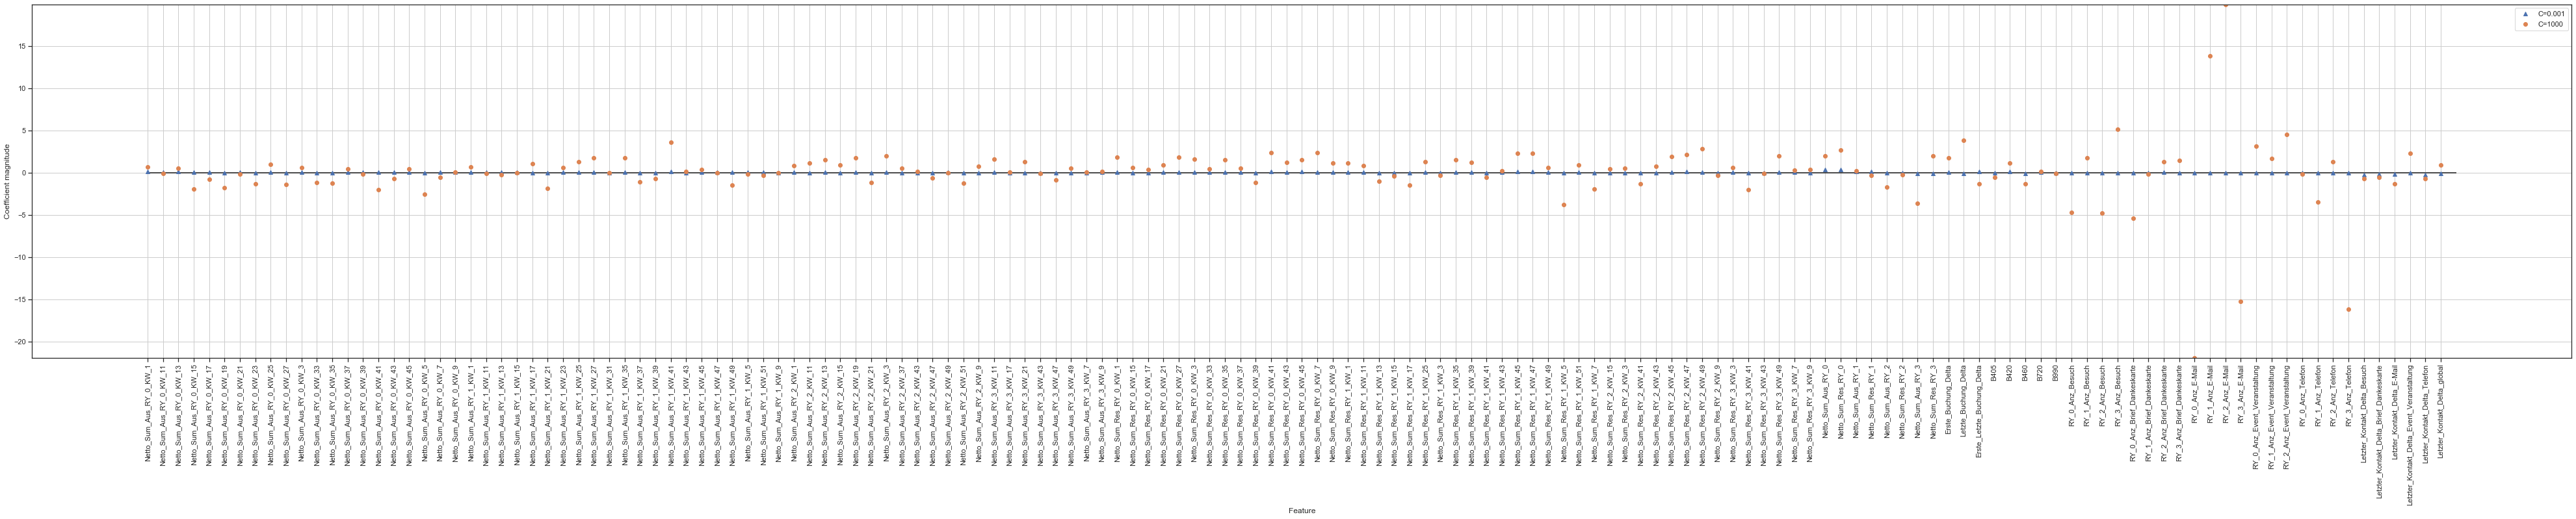

In [80]:
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))

plt.grid()

plt.plot(logreg_C0001.coef_.T,
         '^',
         label="C=0.001"
        )

plt.plot(logreg_C1000.coef_.T,
         'o',
         label="C=1000"
        )

plt.xticks(range(len(feature_columns)),
           feature_columns,
           rotation=90
          )

plt.hlines(0, 0, len(feature_columns))

plt.ylim(min(logreg_C1000.coef_.T),
         max(logreg_C1000.coef_.T)
        )

plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('LogReg_Coefficient_Importance.png')

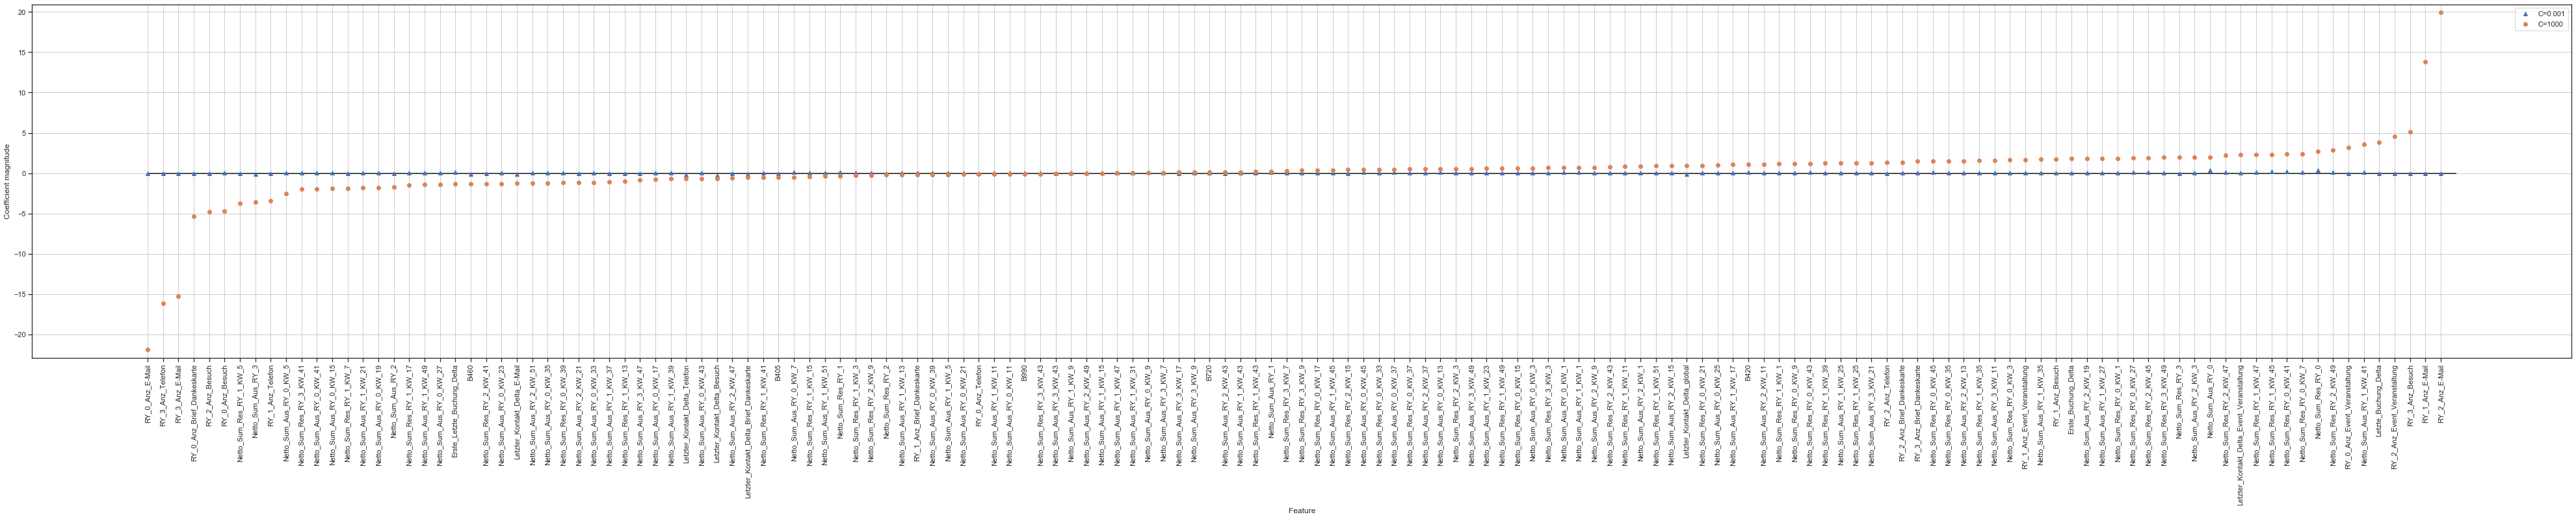

In [82]:
test_df = (
    pd.DataFrame(
        data={'feature': pd.Series(feature_columns), 
              'C1000':   list(logreg_C1000.coef_.T),
              'C0001':   list(logreg_C0001.coef_.T)}
    )
    .sort_values(by=['C1000'])
    .reset_index()
    )
    
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()

plt.plot(
    test_df.loc[:,'C0001'],
    '^', 
    label="C=0.001"
    )

plt.plot(
    test_df.loc[:,'C1000'],
    'o',
    label="C=1000"
    )


plt.xticks(
    range(len(feature_columns)),
    test_df.loc[:,'feature'],
    rotation=90
    )

plt.hlines(0, 0, len(feature_columns))

plt.ylim(
    min(logreg_C1000.coef_.T)-1,
    max(logreg_C1000.coef_.T)+1
    )

plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

del test_df

### Model Training: Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
%%time 
# Wall time: 13min
forest_01 = RandomForestClassifier(
    n_estimators = 5*10**3,
    max_depth    = 10,
    criterion    = 'gini',  #criterion='gini',
    random_state = 42,
    n_jobs       = -1
    )

forest_01.fit(
    X_train_balanced,
    y_train_balanced
    )

Wall time: 17.1 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [85]:
%%time
# %% Validate Accuracy
print(f"Accuracy on balanced training set:   {forest_01.score(X_train_balanced, y_train_balanced)}")
print(f"Accuracy on unbalanced training set: {forest_01.score(X_train,          y_train)}")
print(f"Accuracy on test set (validation):   {forest_01.score(X_test,           y_test)}")

Accuracy on balanced training set:   0.9931120511986116
Accuracy on unbalanced training set: 0.9914421553090332
Accuracy on test set (validation):   0.9676703645007924
Wall time: 5.27 s


In [86]:
# %% Plot: Feature importance
def plot_feature_importances(
        model,
        feature_columns,
        figsize=(20,100)
        ):
    
    from operator import itemgetter
    
    dict_feature_importance = sorted(
        dict(
            zip(feature_columns,model.feature_importances_)
        ).items(),
        key=itemgetter(1)
        )
    
    n_features = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    
    plt.barh(
        np.arange(n_features),
        [y for (x,y) in dict_feature_importance],
        align='center'
        )
    
    plt.yticks(
        np.arange(n_features),
        [x for (x,y) in dict_feature_importance]
        )
    
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

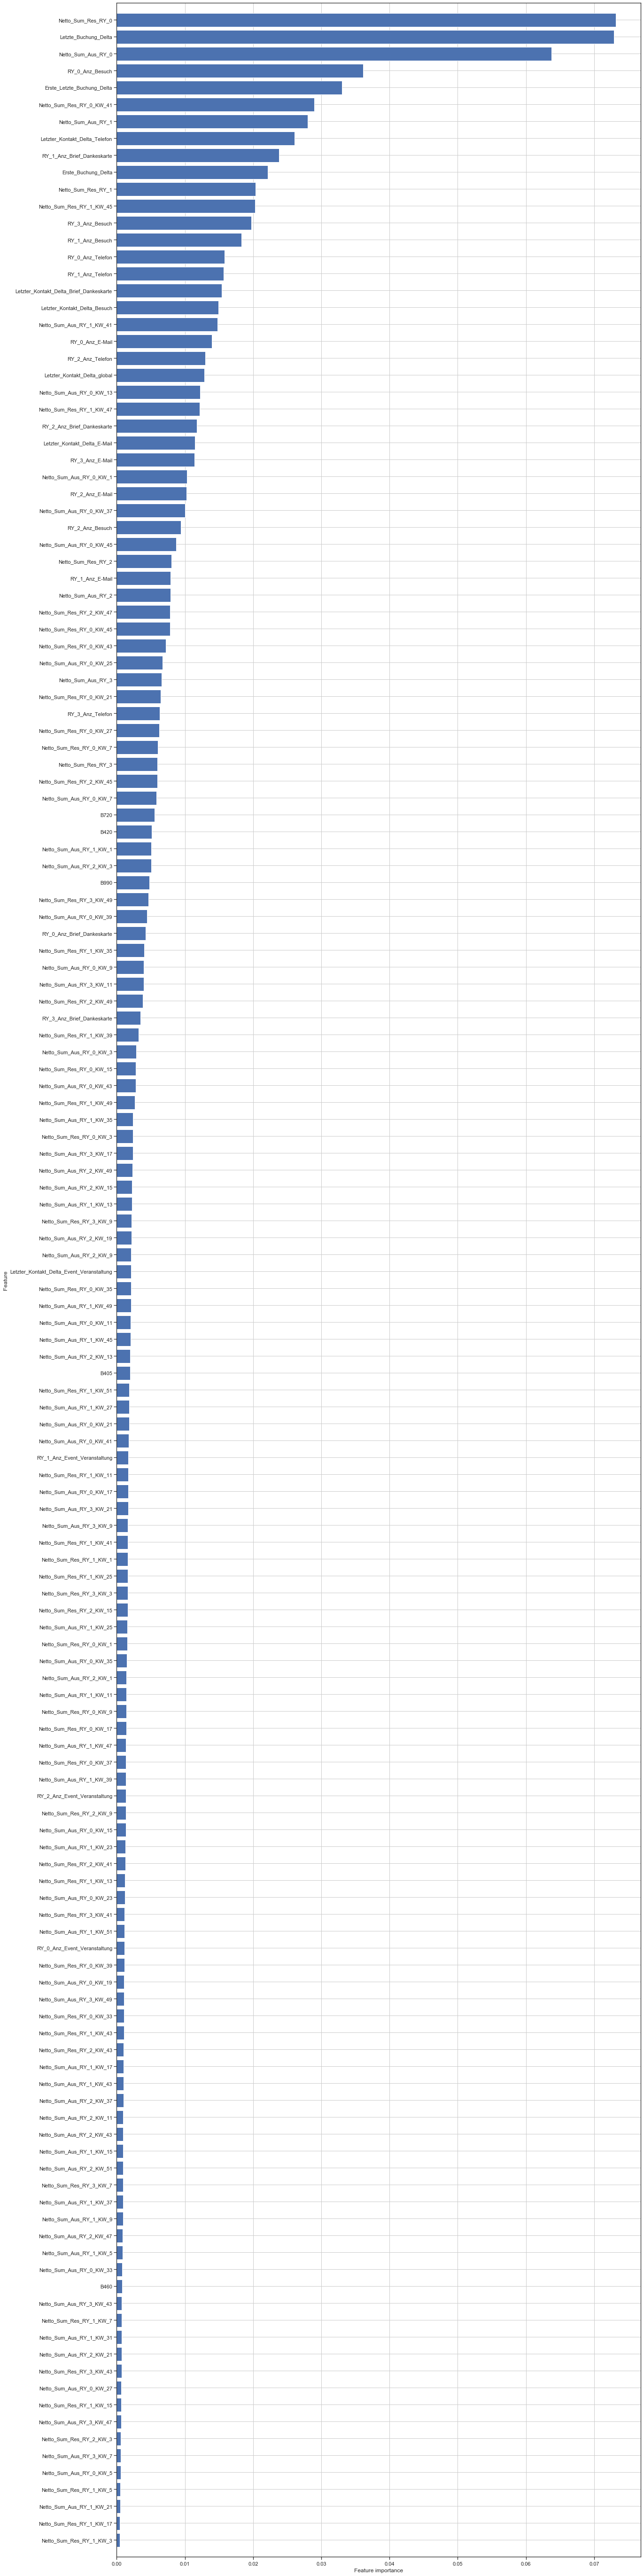

In [87]:
plot_feature_importances(forest_01,feature_columns)

# Model Validation

## Confusion Matrix

In [88]:
from sklearn.metrics import confusion_matrix

In [89]:
%%time

def confusion_matrices(X_test,y_test):
    global pred_forest_01, pred_logreg_C0001, pred_logreg_C1000
    
    pred_forest_01    = forest_01.predict(X_test)
    pred_logreg_C0001 = logreg_C0001.predict(X_test)
    pred_logreg_C1000 = logreg_C1000.predict(X_test)


    # Wall time: 20.9ms

    confusion_logreg_C0001 = (
        confusion_matrix(
            y_test,
            pred_logreg_C0001
            )
        )
    
    df_confusion_logreg_C0001 = (
        pd.DataFrame(
            confusion_logreg_C0001,
            index   = ["Fact 0", "Fact 1"],
            columns = ["Pred 0", "Pred 1"]
            )
        )
    
    confusion_logreg_C1000 = (
        confusion_matrix(
            y_test,
            pred_logreg_C1000
            )
        )
    
    df_confusion_logreg_C1000 = (
        pd.DataFrame(
            confusion_logreg_C1000,
            index   = ["Fact 0", "Fact 1"],
            columns = ["Pred 0", "Pred 1"]
            )
        )

    confusion_forest_01 = (
        confusion_matrix(
            y_test,
            pred_forest_01
            )
        )
    
    df_confusion_forest_01 = (
        pd.DataFrame(
            confusion_forest_01,
            index=["Fact 0", "Fact 1"],
            columns=["Pred 0","Pred 1"]
            )
        )

    print("Test set balance:")
    print(pd.Series(y_test).value_counts())

    print("\nConfusion Matrices:")

    print("\nRandom Forest (forest_01):")
    display(df_confusion_forest_01)

    print("\nLogistic Regression C=0.001:")
    display(df_confusion_logreg_C0001)

    print("\nLogistic Regression C=1000:")
    display(df_confusion_logreg_C1000)

Wall time: 0 ns


In [90]:
confusion_matrices(
    X_test = X_train_balanced,
    y_test = y_train_balanced
    )

Test set balance:
True     9219
False    9219
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,9197,22
Fact 1,105,9114



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,7167,2052
Fact 1,3470,5749



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,7534,1685
Fact 1,1669,7550


In [91]:
confusion_matrices(
    X_test = X_train,
    y_test = y_train
    )

Test set balance:
False    9219
True      246
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,9197,22
Fact 1,59,187



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,7167,2052
Fact 1,69,177



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,7534,1685
Fact 1,53,193


In [92]:
confusion_matrices(
    X_test = X_test,
    y_test = y_test
    )

Test set balance:
False    3090
True       65
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,3041,49
Fact 1,53,12



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,2387,703
Fact 1,19,46



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,2498,592
Fact 1,24,41


1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$ <-- Optimising target!
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


## Classification Report

In [93]:
from sklearn.metrics import classification_report

In [96]:
%%time
## Wall time: 9.94ms

print("\n")
print("Logistic Regression C=0.001:")
print(
    classification_report(
        y_test,
        pred_logreg_C0001,
        target_names=["not booking = 0", "booking = 1"]
        )
    )

print("Logistic Regression C=1000:")
print(
    classification_report(
        y_test,
        pred_logreg_C1000,
        target_names=["not booking = 0", "booking = 1"]
        )
    )

print("Random Forest:")
print(
    classification_report(
        y_test,
        pred_forest_01,
        target_names=["not booking = 0", "booking = 1"]
        )
    )



Logistic Regression C=0.001:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.77      0.87      3090
    booking = 1       0.06      0.71      0.11        65

       accuracy                           0.77      3155
      macro avg       0.53      0.74      0.49      3155
   weighted avg       0.97      0.77      0.85      3155

Logistic Regression C=1000:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.81      0.89      3090
    booking = 1       0.06      0.63      0.12        65

       accuracy                           0.80      3155
      macro avg       0.53      0.72      0.50      3155
   weighted avg       0.97      0.80      0.87      3155

Random Forest:
                 precision    recall  f1-score   support

not booking = 0       0.98      0.98      0.98      3090
    booking = 1       0.20      0.18      0.19        65

       accuracy                           0.97      3155
      

## Precision-Recall Curve

In [97]:
from sklearn.metrics import precision_recall_curve

def prec_rec_values(X_test,y_test):
    global precision_forest_01,    recall_forest_01,    thresholds_forest_01
    global precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001
    global precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 
    
    
    # LogReg C=0.001
    (precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001) = (
        precision_recall_curve(
            y_test, 
            logreg_C0001.predict_proba(X_test)[:,1]
            )
        )
    
    
    # LogReg C=1000
    (precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000) = (
        precision_recall_curve(
            y_test, 
            logreg_C1000.predict_proba(X_test)[:,1]
            )
        )
    
    
    # RandomForestClassifier has predict_proba, but not decision_function
    (precision_forest_01, recall_forest_01, thresholds_forest_01) = (
        precision_recall_curve(
            y_test,
            forest_01.predict_proba(X_test)[:, 1]
            )
        )
    
    

In [98]:
%%time
# Wall time: 22.4s

def prec_rec_curve(X_train,y_train):
    prec_rec_values(X_train,y_train)

    plt.figure(figsize=(15,12))
    plt.grid()

    def optimum_point(precision_forest_01,
                      recall_forest_01,
                      thresholds_forest_01,
                      name,
                      dot):
        
        optimum_idx = (
            pd.Series.idxmin(
                np.power(1-pd.Series(precision_forest_01),2)
                + np.power(1-pd.Series(recall_forest_01),2)
                )
            )
        
        return plt.plot(precision_forest_01[optimum_idx],
                     recall_forest_01[optimum_idx],
                     dot,
                     markersize = 10,
                     label      = f"{name}: threshold {thresholds_forest_01[optimum_idx]}",
                     fillstyle  = "none",
                     c          = 'k',
                     mew        = 2
                     )

    
    ## Apply optium_point():
    
    # Optimum: Forest 
    optimum_point(precision_forest_01,
                  recall_forest_01,
                  thresholds_forest_01,
                  name="forest_01",
                  dot='o'
                 )
    
    # Optimum: LogReg C = 0.001
    optimum_point(precision_logreg_C0001,
                  recall_logreg_C0001,
                  thresholds_logreg_C0001,
                  name="logreg_C0001",
                  dot='x'
                 )
    
    # Optimum: LogReg C = 1000
    optimum_point(precision_logreg_C1000,
                  recall_logreg_C1000,
                  thresholds_logreg_C1000,
                  name="logreg_C1000",
                  dot='+'
                 )
    
    # Prec-Rec Curve: LogReg C = 0.001
    plt.plot(precision_logreg_C0001,
             recall_logreg_C0001,
             label="Logistic Regression, C=0.001"
            )
    
    # Prec-Rec Curve: LogReg C = 1000
    plt.plot(precision_logreg_C1000,
             recall_logreg_C1000,
             label="Logistic Regression, C=1000"
            )
    
    # Prec-Rec Curve: Forest
    plt.plot(precision_forest_01,
             recall_forest_01,
             label="Random Forest"
            )

    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend(loc="best")

    plt.show()

Wall time: 0 ns


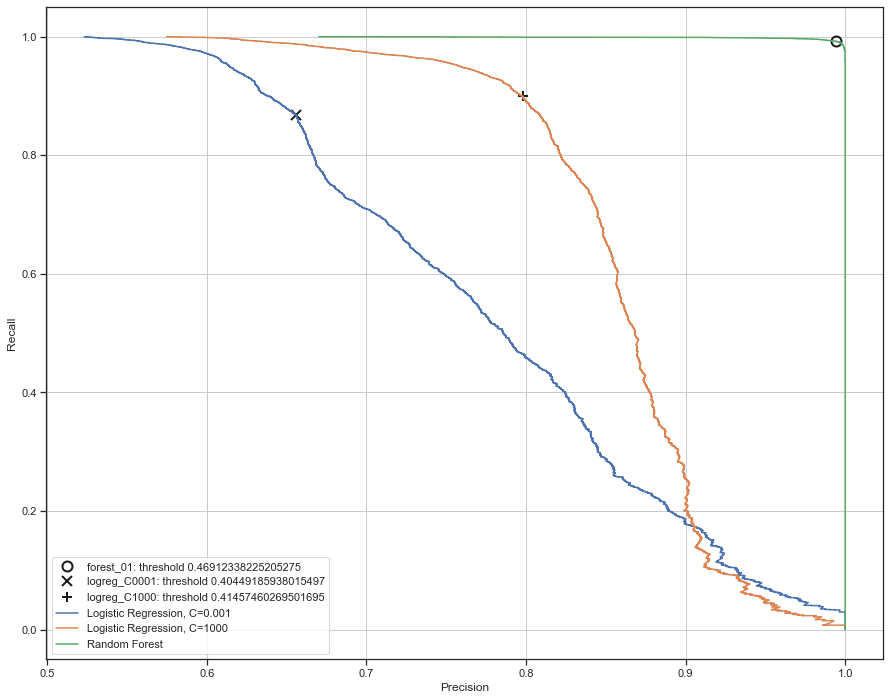

In [99]:
prec_rec_curve(
    X_train = X_train_balanced,
    y_train = y_train_balanced
    )

=> Should give very nice curves, because models have been trained on this data.

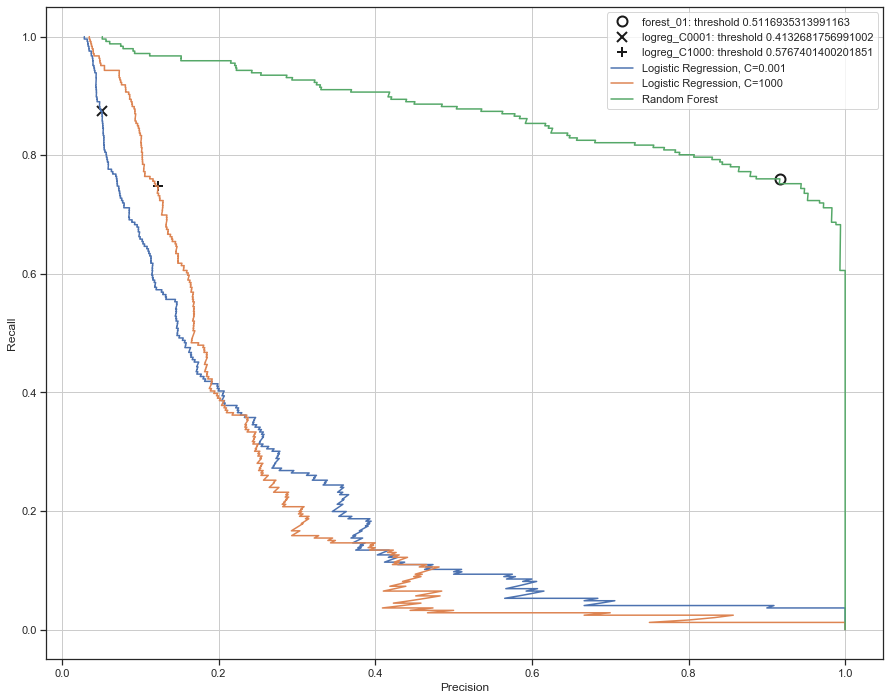

In [100]:
prec_rec_curve(
    X_train = X_train,
    y_train = y_train
    )

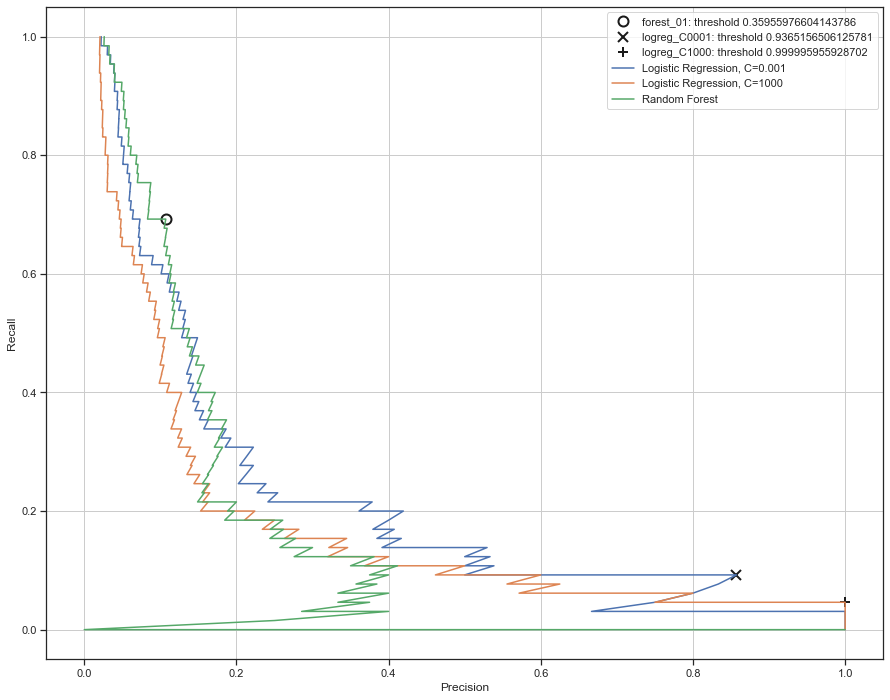

In [101]:
prec_rec_curve(
    X_train = X_test,
    y_train = y_test
    )

In [103]:
%%time
#Wall time: 19.7 s

# Area under the Recall/Precision-curves:
from sklearn.metrics import average_precision_score 

avg_precision_logreg_C0001 = (
    average_precision_score(
        y_test,
        logreg_C0001.predict_proba(X_test)[:, 1]
        )
    )

avg_precision_logreg_C1000 = (
    average_precision_score(
        y_test,
        logreg_C1000.predict_proba(X_test)[:, 1]
        )
    )

avg_precision_forest_01 = (
    average_precision_score(
        y_test,
        forest_01.predict_proba(X_test)[:, 1]
        )
    )


print(f"Average Precision of LogReg C=0.001: {avg_precision_logreg_C0001}")
print(f"Average Precision of LogReg C=1000:  {avg_precision_logreg_C1000}")
print(f"Average Precision of forest_01:      {avg_precision_forest_01}")

Average Precision of LogReg C=0.001: 0.22149714926848058
Average Precision of LogReg C=1000:  0.175003512690083
Average Precision of forest_01:      0.15603517787731488
Wall time: 1.52 s


=> Winner: Forest

## Receiver Operating Characteristics (ROC) and AUC


In [104]:
%%time
from sklearn.metrics import roc_curve
def roc_curve_graph(X_test,y_test):
    global fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001
    global fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000
    global fpr_forest_01, tpr_forest_01, thresholds_forest_01
    
    (fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001) = (
        roc_curve(
            y_test,
            logreg_C0001.predict_proba(X_test)[:, 1]
            )
        )
    
    
    (fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000) = (
        roc_curve(
            y_test,
            logreg_C1000.predict_proba(X_test)[:, 1]
            )
        )
    
    (fpr_forest_01, tpr_forest_01, thresholds_forest_01) = (
        roc_curve(
            y_test,
            forest_01.predict_proba(X_test)[:, 1]
            )
        )

    def threshold_dot_50perc(fpr_forest_01,
                             tpr_forest_01,
                             thresholds_forest_01,
                             name,
                             dot):

        close_default_index_forest_01 = (
            pd.Series.idxmin(
                np.power(1-pd.Series(tpr_forest_01),2)
                +np.power(pd.Series(fpr_forest_01),2)
                )
            )
        
        return plt.plot(
            fpr_forest_01[close_default_index_forest_01],
            tpr_forest_01[close_default_index_forest_01],
            dot,
            markersize=10,
            label=f"{name} threshold: {thresholds_forest_01[close_default_index_forest_01]}",
            fillstyle="none",
            c='k',
            mew=2)


    plt.figure(figsize=(15,12))
    plt.grid()

    plt.plot(fpr_forest_01,
             fpr_forest_01,
             linestyle='dotted',
             label="base line"
            )

    plt.plot(fpr_logreg_C0001,
             tpr_logreg_C0001,
             label="logreg_C0001"
            )
    
    plt.plot(fpr_logreg_C1000,
             tpr_logreg_C1000,
             label="logreg_C1000"
            )
    
    plt.plot(fpr_forest_01,
             tpr_forest_01,
             label="forest_01"
            )


    plt.xlabel("False-Postive Rate (FPR)")
    plt.ylabel("True-Positive Rate (TPR) aka. Recall")

    # find threshold closest to zero
    threshold_dot_50perc(fpr_forest_01,
                         tpr_forest_01,
                         thresholds_forest_01,
                         'forest_01',
                         dot='^'
                        )
    
    threshold_dot_50perc(fpr_logreg_C0001,
                         tpr_logreg_C0001,
                         thresholds_logreg_C0001,
                         'logreg_C0001',
                         dot='x'
                        )
    
    threshold_dot_50perc(fpr_logreg_C1000,
                         tpr_logreg_C1000,
                         thresholds_logreg_C1000,
                         'logreg_C1000',
                         dot='+'
                        )

    plt.legend(loc=4)
    plt.show()

Wall time: 0 ns


In [105]:
%%time
# Wall time: 17.6s
from sklearn.metrics import roc_auc_score

def roc_auc(X_test,y_test):
    forest_01_auc = roc_auc_score(
        y_test,
        forest_01.predict_proba(X_test)[:, 1]
        )
    
    logreg_C0001_auc = roc_auc_score(
        y_test,
        logreg_C0001.predict_proba(X_test)[:, 1]
        )
    
    logreg_C1000_auc = roc_auc_score(
        y_test,
        logreg_C1000.predict_proba(X_test)[:, 1]
        )


    print("AUC for forest_01:    {:.3f}".format(forest_01_auc))
    print("AUC for logreg_C0001: {:.3f}".format(logreg_C0001_auc))
    print("AUC for logreg_C1000: {:.3f}".format(logreg_C1000_auc))

Wall time: 0 ns


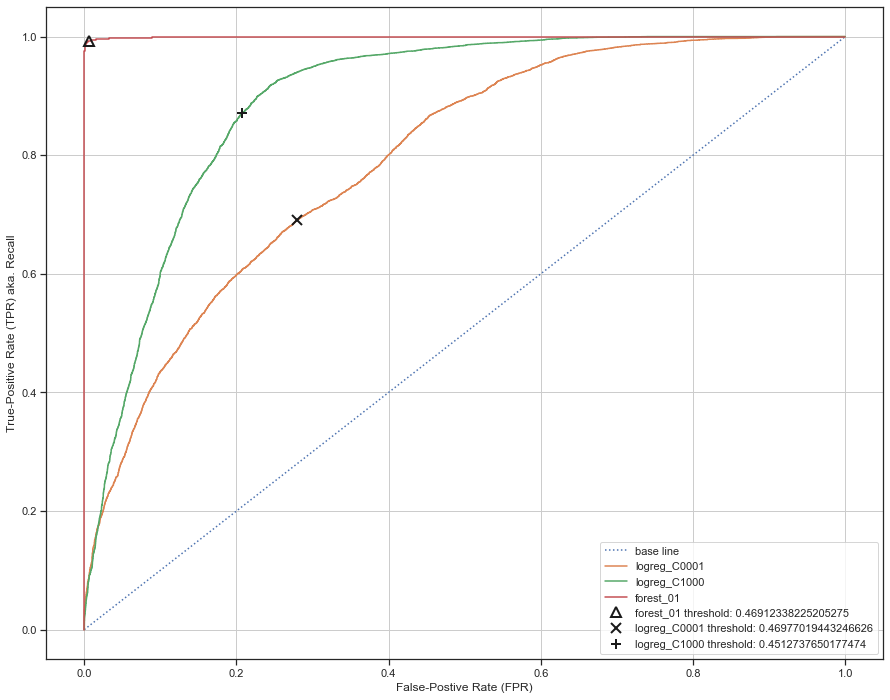

AUC for forest_01:    0.999
AUC for logreg_C0001: 0.794
AUC for logreg_C1000: 0.894
Wall time: 4.2 s


In [106]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train_balanced,
                y_train_balanced
               )

roc_auc(X_train_balanced,
        y_train_balanced
       )

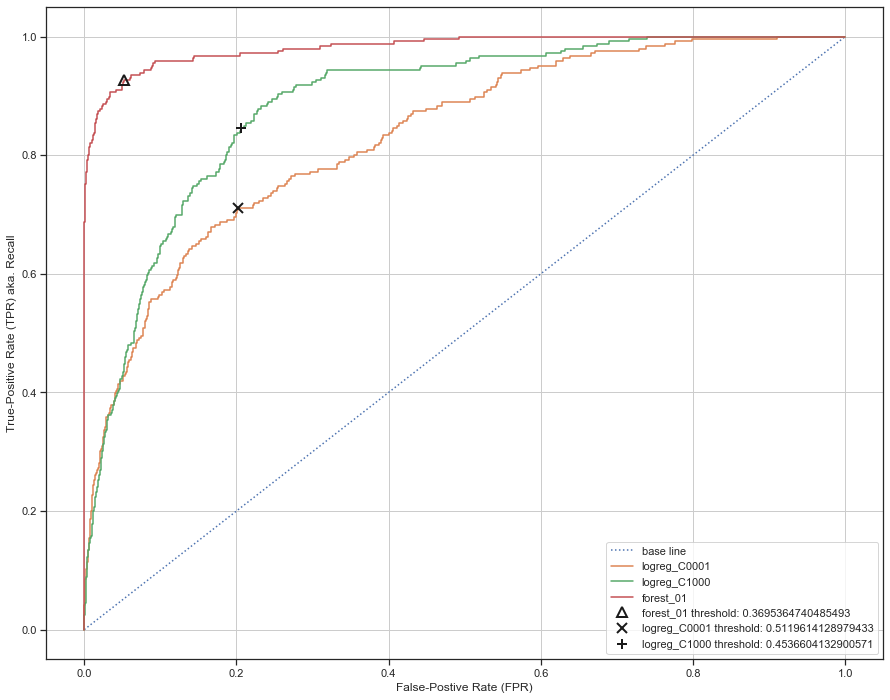

AUC for forest_01:    0.982
AUC for logreg_C0001: 0.832
AUC for logreg_C1000: 0.888
Wall time: 3.74 s


In [107]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train,
                y_train
               )

roc_auc(X_train,
        y_train
       )

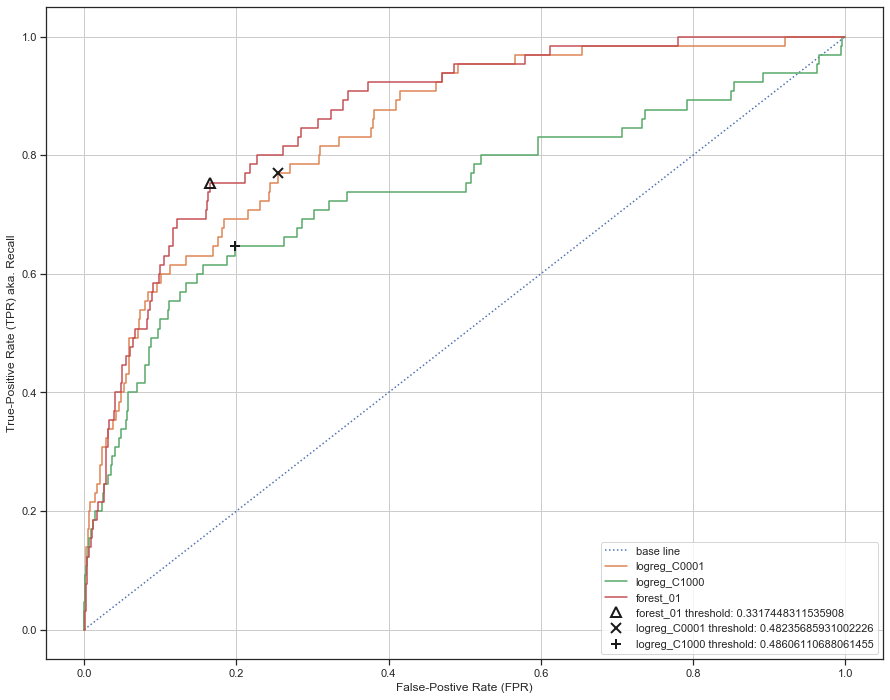

AUC for forest_01:    0.864
AUC for logreg_C0001: 0.843
AUC for logreg_C1000: 0.739
Wall time: 3.34 s


In [108]:
%%time
roc_curve_graph(X_test,
                y_test
               )

roc_auc(X_test,
        y_test
       )

# Scoring

## Score Class Probabilities (Booking: No/Yes)

In [109]:
scoring_prob     = forest_01.predict_proba(X_scoring)

scoring_prob_df  = pd.DataFrame(scoring_prob,
                                columns=["Prob_0","Prob_1"]
                               )

scoring_all_prob = (pd.merge(scoring_all,
                             scoring_prob_df,
                             left_index=True,
                             right_index=True
                            ).sort_values("Prob_1",ascending=False)
                   )

In [110]:
scoring_all_prob.head(4)

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_27,Netto_Sum_Aus_RY_0_KW_29,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_31,Netto_Sum_Aus_RY_0_KW_33,Netto_Sum_Aus_RY_0_KW_35,Netto_Sum_Aus_RY_0_KW_37,Netto_Sum_Aus_RY_0_KW_39,Netto_Sum_Aus_RY_0_KW_41,Netto_Sum_Aus_RY_0_KW_43,Netto_Sum_Aus_RY_0_KW_45,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_27,Netto_Sum_Res_RY_0_KW_29,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_31,Netto_Sum_Res_RY_0_KW_33,Netto_Sum_Res_RY_0_KW_35,Netto_Sum_Res_RY_0_KW_37,Netto_Sum_Res_RY_0_KW_39,Netto_Sum_Res_RY_0_KW_41,Netto_Sum_Res_RY_0_KW_43,Netto_Sum_Res_RY_0_KW_45,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_1

## Backup for comparision with Rscript

In [111]:
backup_scorings_df =  scoring_all_prob.loc[:,["Endkunde_NR","Prob_1"]]

with project_dir("vkprog\\predictions"):
    store_bin(backup_scorings_df, "20191118_pred_rebuild_with_sales_filter.feather")


14:09:56 [INFO] Started storing binary file
14:09:56 [INFO] Writing to file C:\Users\stc\data\vkprog\predictions\20191118_pred_rebuild_with_sales_filter.feather
14:09:56 [INFO] Written 299.5 KB
14:09:56 [INFO] Finished storing binary file in 0.01s (0.0s CPU)


## Adding additional information for delivery lists ``EK_LIST_2W_KOMPLETT.csv``

In [112]:
from pa_lib.file import load_bin

In [113]:
ek_info = load_bin("vkprog\\ek_info.feather")

14:10:17 [INFO] Started loading binary file
14:10:17 [INFO] Reading from file C:\Users\stc\data\vkprog\ek_info.feather
14:10:17 [INFO] Finished loading binary file in 0.04s (0.03s CPU)


In [114]:
ek_list_raw = pd.merge(scoring_all_prob,ek_info,on="Endkunde_NR", how="left")

In [115]:
ek_list_raw.shape

(12763, 385)

In [116]:
# Check _col_selection_ in file "vp2xlsx.py". 
# It's the only one that actually counts! 
# Compare with R-code to figure out the meaning.

net_columns = [col for col in ek_info.columns if col.startswith("Net_")]

col_row_filter =([
    "Insolvenz",
    #"Last_Res_Date",  # covered in listing
    #"Last_Aus_Date",  # covered in listing
    "last_CRM_Ktkt_date",
    "VB_FILTER_VON",
    "VB_FILTER_BIS"
    ])

listing = (
    ["Endkunde_NR",      # Endkunde_NR
     "Endkunde",         # Endkunde
     "EK_HB_Apg_Kurzz",  # HB_APG (based on R-script)
     "Agentur",          # Agentur
     "AG_Hauptbetreuer", # HB_Agentur   
     "PLZ",              # PLZ
     "GEMEINDE"]        # Ort
    
     +net_columns       # Net_2015, Net_2016, Net_2017, Net_2018, Net_2019 
    
     +["letzte_VBs",     # (bd, aggregiert)
       "Letzter_Kontakt", # KZ_letzter_Ktkt (crm)
       "Kanal",           #(crm)
       "Betreff",         #(crm)    
       "Last_Res_Date", # Letzte_Kamp_erfasst
       "Last_Aus_Date", # letzte_Kamp_Beginn
       "VERKAUFS_GEBIETS_CODE", # Verkaufsgebiet
       "VB_VKGEB",      
       "Prob_1"        # prob_KW (from here, good good.)
       ]
    # Needed for row_filter
    + col_row_filter
    )

ek_list = (ek_list_raw
    .loc[:,listing]
    .rename(columns={
        "EK_HB_Apg_Kurzz": "HB_APG",
        "AG_Hauptbetreuer": "HB_Agentur",
        "GEMEINDE": "Ort",
        "Letzter_Kontakt": "letzter_Kontakt",
        "Last_Res_Date": "letzte_Kamp_erfasst",
        "Last_Aus_Date":"letzte_Kamp_Beginn",
        "VERKAUFS_GEBIETS_CODE": "Verkaufsgebiet",
        "VB_VKGEB": "VB_VK_Geb",
        "Prob_1": "prob_KW"
    })       
    )

print(f"ek_list.shape: {ek_list.shape}")

ek_list.shape: (12763, 25)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [117]:
ek_list.sample(10)

,Endkunde_NR,Endkunde,HB_APG,Agentur,HB_Agentur,PLZ,Ort,Net_2015,Net_2016,Net_2017,Net_2018,Net_2019,letzte_VBs,letzter_Kontakt,Kanal,Betreff,letzte_Kamp_erfasst,letzte_Kamp_Beginn,Verkaufsgebiet,VB_VK_Geb,prob_KW,Insolvenz,last_CRM_Ktkt_date,VB_FILTER_VON,VB_FILTER_BIS
11711,118919,Garage Bolzern AG,OSS,ACE 2 ACE outdoor media ag,BAM,6012,Obernau,0.0,0.0,774.0,0.0,0.0,NaN,BIM,E-Mail,Mitte - Aktionen - 2018 - RUC | Sommeraktion 2018,2017-08-24,2017-09-25,V-M08,,0.099100,None,2018-06-07,NaT,NaT
1997,164293,Lampart Silja,JCO,None,None,6016,Hellbühl,306.0,306.0,311.0,311.0,315.0,NaN,JCO,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-10-07,2020-02-10,V-M07,JCO,0.407182,None,2019-10-26,NaT,NaT
2420,591276,Chinderhuus Märlizauber,RPO,looksnice.ch,RPO,4144,Arlesheim,0.0,1031.0,1031.0,1308.0,1356.0,NaN,CKT,E-Mail,Mitte - Aktionen 2019 - ROF | 50% City ePanels...,2019-05-21,2019-06-03,V-M01,RPO,0.386501,None,2019-02-27,NaT,NaT
12475,632769,Telerad SA,PIE,None,None,1950,Sion,0.0,0.0,9718.0,0.0,0.0,NaN,None,None,None,2017-08-28,2017-10-02,V-W05,PIE,0.060473,None,NaT,NaT,NaT
7407,504485,Association de l'Opéra Décentralisé NE,MTO,None,None,2012,Auvernier,1652.0,3666.0,3204.0,3880.0,4185.0,NaN,VJE,E-Mail,RE: Réseau Citysérie F4 - Jardins Musicaux 101...,2019-10-10,2020-06-08,V-W04,VIT,0.247643,None,2019-10-29,NaT,NaT
6290,622661,Mediadschungel GmbH,BON,None,None,7012,Felsberg,0.0,0.0,0.0,4900.0,20795.0,NaN,GBE,E-Mail,"Zentralwäscherei Chur: Offerte Plakate, ePanel...",2019-10-18,2020-01-31,V-SO01,,0.275928,None,2019-11-11,NaT,NaT
5359,472571,Bildungszentrum für Technik BZT,SFA,Koch Kommunikation AG,SFA,8500,Frauenfeld,12225.0,6500.0,6500.0,6500.0,6500.0,NaN,SFA,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-11-01,2020-02-01,V-O04,REM,0.300202,None,2019-10-27,NaT,NaT
266,120004,Zoo Zürich AG,CGA,None,None,8044,Zürich,132836.0,60909.0,193959.0,254728.0,255734.0,NaN,NIE,Besuch,Kundenevent Michael Bublé,2019-10-17,2020-03-30,V-Z01,,0.571338,None,2019-09-25,NaT,NaT
3883,631791,Immo Gäu AG,MWY,Blickwinkel AG,JCO,4616,Kappel SO,0.0,0.0,851.0,0.0,741.0,NaN,MWY,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-07-25,2019-09-09,V-M03,RIN,0.332505,None,2019-10-26,NaT,NaT
6319,659664,Oliveira's,JCO,None,None,6006,Luzern,0.0,0.0,0.0,0.0,500.0,NaN,JCO,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-09-27,2019-09-30,V-M07,JCO,0.275133,None,2019-10-25,NaT,NaT


In [118]:
desc_col(ek_list)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12763,12763
Endkunde,object,0/12763,12164
HB_APG,object,318/12445,62
Agentur,object,7516/5247,1800
HB_Agentur,object,7559/5204,93
PLZ,int64,0/12763,2007
Ort,object,6/12757,1949
Net_2015,float64,4/12759,3674
Net_2016,float64,4/12759,4512
Net_2017,float64,4/12759,4585


## Deployment for ``vp2xlsx.py``

In [119]:
with project_dir("vkprog\\predictions"):
    store_bin(ek_list, "20191118_ek_list.feather")

14:10:35 [INFO] Started storing binary file
14:10:35 [INFO] Writing to file C:\Users\stc\data\vkprog\predictions\20191118_ek_list.feather
14:10:35 [INFO] Written 3.2 MB
14:10:35 [INFO] Finished storing binary file in 0.03s (0.03s CPU)


# Appendix

## Mutual Information

In [ ]:
%%time
mu_in = (mutual_info_classif(X_train_balanced,y_train_balanced) / mutual_info_classif(y_train_balanced.reshape(-1,1),y_train_balanced))

In [ ]:
print(mu_in.shape)
print(feature_columns.shape)

In [ ]:
 mu_in_df = (
     pd.DataFrame(
         {'Feature':           feature_columns,
          'Mutual_Information': mu_in}
         )
     .sort_values(by        = 'Mutual_Information',
                  ascending = False
                 )
     .reset_index(drop=True)
     )

In [ ]:
display(mu_in_df.head(50))

In [ ]:
boxplot_histogram(mu_in_df.loc[:,'Mutual_Information'])

In [ ]:
def mu_in_cutoff(cutoff):
    display(mu_in_df.loc[mu_in_df.loc[:,'Mutual_Information'] >= cutoff,:])

In [ ]:
mu_in_cutoff(0.07)

In [ ]:
mu_in_df['scaled'] = mu_in_df['Mutual_Information'] / mu_in_df['Mutual_Information'].sum()

In [ ]:
mu_in_df['cum'] = mu_in_df['scaled'].cumsum()

In [ ]:
plt.figure(figsize=(15,50))
sns.barplot(x   = 'Mutual_Information',
            y   = 'Feature',
            data= mu_in_df)

## Univariate Analysis

In [ ]:
for feature in feature_columns:
    print(feature)
    print(len(training_all.loc[training_all.loc[:,feature] > 0, feature]))
    boxplot_histogram(training_all.loc[training_all.loc[:,feature] > 0, feature])

## Bivariate Analysis

In [ ]:
training_all.describe()

In [ ]:
print(training_all.columns)

In [ ]:
def hexbin(dataset, first_feature,second_feature,gridsize=25):
    dataset.plot.hexbin(x=first_feature, y=second_feature , gridsize=gridsize, figsize=(12,8))

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=10, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(training_all,
                      hue="Target_Res_flg",
                      col="Target_Res_flg",
                      height=10
                     )

g.map(hexbin,
      "Netto_Sum_Aus_RY_0_KW_1",
      "Erste_Buchung_Delta",
      extent=[0, 1, 0, 1]
     )

In [ ]:
%%time
sns.axes_style("darkgrid")

sns.pairplot(data   = training_all.loc[:,["Target_Res_flg"]+list(mu_in_df.head(20).loc[:,"Feature"])],
             diag_kind="kde",
             hue    = "Target_Res_flg",
             height =5
            ).savefig("derp.png")
